In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from IPython.display import Image, display

In [2]:
from keras.preprocessing import image, sequence
from keras.layers import Dense, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
pd_dataset = pd.read_csv("./Flickr8k_text/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print ds.shape

(30000, 2)


In [4]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print len(sentences)

30000


In [5]:
words = [i.split() for i in sentences]

In [6]:
unique = []
for i in words:
    unique.extend(i)

In [7]:
unique = list(set(unique))
print len(unique)

vocab_size = len(unique)

8253


In [10]:
#Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [11]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

In [12]:
print word_2_indices['<start>']
print indices_2_word[4011]
print word_2_indices['<end>']
print indices_2_word[8051]

4011
<start>
8051
<end>


In [13]:
vocab_size = len(word_2_indices.keys())
print vocab_size

8254


### Model

In [14]:
captions = np.load("./captions.npy")
next_words = np.load("./next_words.npy")

print captions.shape
print next_words.shape

(25493, 40)
(25493, 8254)


In [15]:
images = np.load("./images.npy")

print images.shape

(25493, 2048)


In [18]:
imag = np.load("./image_names.npy")
        
print imag.shape

(25493,)


In [16]:
embedding_size = 128
max_len = 40

In [17]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [18]:
plot_model(image_model, show_shapes=True, to_file='image_model.png')

In [19]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056512   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [20]:
plot_model(language_model, show_shapes=True, to_file='language_model.png')

In [21]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

model.load_weights("./model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      1056512     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          262272      dense_1_input[0][0]              
__________________________________________________________________________________________________
lstm_1 (LS

In [22]:
plot_model(model, show_shapes=True, to_file='image_cap_model.png')

In [46]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=10)

Epoch 1/10
25493/25493 [==============================] - 149s 6ms/step - loss: 1.0466 - acc: 0.6587
Epoch 2/10
25493/25493 [==============================] - 168s 7ms/step - loss: 0.8866 - acc: 0.7038
Epoch 3/10
25493/25493 [==============================] - 185s 7ms/step - loss: 0.8614 - acc: 0.7094
Epoch 4/10
25493/25493 [==============================] - 193s 8ms/step - loss: 0.8393 - acc: 0.7165
Epoch 5/10
25493/25493 [==============================] - 215s 8ms/step - loss: 0.8233 - acc: 0.7229
Epoch 6/10
25493/25493 [==============================] - 175s 7ms/step - loss: 0.7995 - acc: 0.7250
Epoch 7/10
25493/25493 [==============================] - 204s 8ms/step - loss: 0.7868 - acc: 0.7329
Epoch 8/10
25493/25493 [==============================] - 187s 7ms/step - loss: 0.7678 - acc: 0.7366
Epoch 9/10
25493/25493 [==============================] - 203s 8ms/step - loss: 0.7487 - acc: 0.7450
Epoch 10/10
25493/25493 [==============================] - 173s 7ms/step - loss: 0.7299 - a

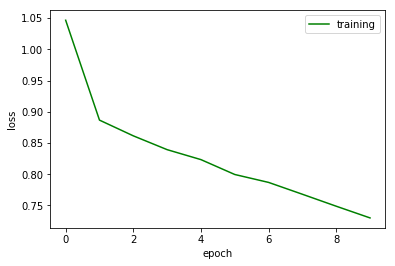

In [48]:
plt.figure(0)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(hist.history['loss'],'g')
plt.legend(['training'])
plt.savefig('imgcap_loss_plots.png')
plt.show()

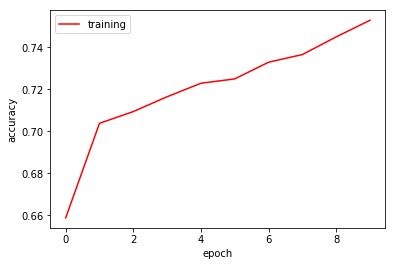

In [49]:
plt.figure(1)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(hist.history['acc'],'r')
plt.legend(['training'])
plt.savefig('imgcap_accuracy_plots.png')
plt.show()

In [1]:
model.save_weights("./model_weights.h5")

NameError: name 'model' is not defined

### Predictions

In [23]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [24]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [25]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [31]:
img = "./im_cap_mid/doggo.jpg"
#img = "/home/vasu/Downloads/aaaaaaa.jpeg"
test_img = get_encoding(resnet, img)

In [32]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

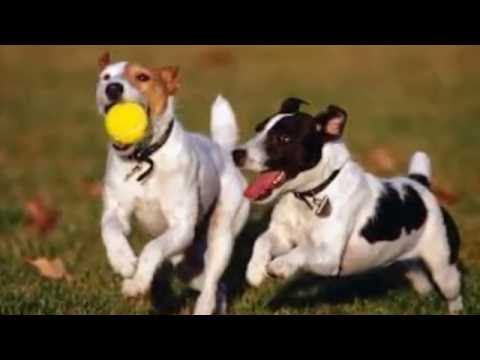

Two dogs running running white dog dog a brown dog the grass .


In [33]:
z = Image(filename=img)
display(z)

print (Argmax_Search)